In [1]:
import pandas as pd
import argparse
import json


from bs4 import BeautifulSoup
from collections import Counter
from textractor import Textractor
from unstructured.partition.pdf import partition_pdf
from textractor.data.constants import TextractFeatures

In [2]:
from pdf2image import convert_from_path
from PIL import Image


def extract_page_as_image(pdf_path, page_number, output_image_path, crop_coords=None):
    images = convert_from_path(pdf_path, first_page=page_number, last_page=page_number)
    
    if crop_coords:
        left = min(point[0] for point in crop_coords)
        top = min(point[1] for point in crop_coords)
        right = max(point[0] for point in crop_coords)
        bottom = max(point[1] for point in crop_coords)
        images[0] = images[0].crop((left, top, right, bottom))
    
    images[0].save(output_image_path, 'PNG')

In [3]:
extractor = Textractor(profile_name="default")

In [4]:
def parse_command_line_arguments():
    parser = argparse.ArgumentParser()

    parser.add_argument('--document_path', type=str, help='The path to the input PDF document.')
    parser.add_argument('--save_path', type=str, help='The path where to print the parsed json document.')

    return parser.parse_args()

def prepare_counter(elements):
    titles_text = [el.text for el in elements if el.category == "Title"]
    text_text = [el.text for el in elements if el.category == "Text"]
    narrtext_text = [el.text for el in elements if el.category == "NarrativeText"]

    all_text = titles_text + narrtext_text + text_text
    all_counter = Counter(all_text)

    return all_counter

def create_parsed_dictionary(elements, all_counter):
    parsed_doc = {'page_1': ''}
    curr_page = 'page_1'
    page_number = 1

    for el in elements:
        if el.category == 'PageBreak':
            page_number += 1
            curr_page = f"page_{page_number}"
            parsed_doc[curr_page] = ''

        elif el.category == 'ListItem':
            if all_counter[el.text] < 10 and all_counter[el.text] != 0:
                parsed_doc[curr_page] += el.text
                parsed_doc[curr_page] += '\n'
        
        elif el.category == 'NarrativeText':
            if all_counter[el.text] < 10 and all_counter[el.text] != 0:
                parsed_doc[curr_page] += el.text
                parsed_doc[curr_page] += ' '

        elif el.category == 'Table':
            parsed_doc[curr_page] += '\n'
            parsed_doc[curr_page] += el.metadata.text_as_html
            parsed_doc[curr_page] += '\n'

        elif el.category == 'Text':
            if all_counter[el.text] < 10 and all_counter[el.text] != 0:
                parsed_doc[curr_page] += el.text
                parsed_doc[curr_page] += ' '

        elif el.category == 'Title':
            if page_number == 1:
                parsed_doc[curr_page] += el.text
                parsed_doc[curr_page] += '\n'
            elif all_counter[el.text] < 10 and all_counter[el.text] != 0:
                parsed_doc[curr_page] += el.text
                parsed_doc[curr_page] += '\n'
        

    parsed_doc = {k:v for k,v in parsed_doc.items() if v}   

    return parsed_doc

In [5]:
def save_parsed_document(parsed_doc, save_path):
    """
    Saves the parsed document to the specified path
    """
    with open(save_path, 'w') as f:
        json.dump(parsed_doc, f)

In [6]:
elements = partition_pdf(filename='DPC0FQ-JD14-M1001-KB022-00.pdf', infer_table_structure=True, include_page_breaks=True, languages=['ita', 'eng'])
all_counter = prepare_counter(elements=elements)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
filename='DPC0FQ-JD14-M1001-KB022-00.pdf'

In [17]:
tablas = []

In [39]:
parsed_doc = {'page_1': ''}
curr_page = 'page_1'
page_number = 1
n=0

for el in elements:
    if el.category == 'PageBreak':
        page_number += 1
        curr_page = f"page_{page_number}"
        parsed_doc[curr_page] = ''

    elif el.category == 'ListItem':
        if all_counter[el.text] < 10 and all_counter[el.text] != 0:
            parsed_doc[curr_page] += el.text
            parsed_doc[curr_page] += '\n'
    
    elif el.category == 'NarrativeText':
        if all_counter[el.text] < 10 and all_counter[el.text] != 0:
            parsed_doc[curr_page] += el.text
            parsed_doc[curr_page] += ' '

    elif el.category == 'Table':
        parsed_doc[curr_page] += '\n'
        pdf_path = filename
        page_number = el.metadata.page_number 
        coords = el.metadata.coordinates.points 
        output_image_path = f'output_{n}.png'
        extract_page_as_image(pdf_path, page_number, output_image_path, coords)
        document = extractor.analyze_document(file_source=f'output_{n}.png',features=[TextractFeatures.TABLES])
        table_html = document.tables[0].to_pandas().to_html()
        tablas.append(document.tables[0].to_pandas())
        parsed_doc[curr_page] += table_html
        parsed_doc[curr_page] += '\n'
        n+=1
        

    elif el.category == 'Text':
        if all_counter[el.text] < 10 and all_counter[el.text] != 0:
            parsed_doc[curr_page] += el.text
            parsed_doc[curr_page] += ' '

    elif el.category == 'Title':
        if page_number == 1:
            parsed_doc[curr_page] += el.text
            parsed_doc[curr_page] += '\n'
        elif all_counter[el.text] < 10 and all_counter[el.text] != 0:
            parsed_doc[curr_page] += el.text
            parsed_doc[curr_page] += '\n'
    
# Remove all empty entries.
parsed_doc = {k:v for k,v in parsed_doc.items() if v} 

In [24]:
for index, el in enumerate(elements):
    if el.category == 'Table':
        print(f"Element at position {index} is a Table")

Element at position 12 is a Table
Element at position 404 is a Table
Element at position 608 is a Table
Element at position 734 is a Table
Element at position 738 is a Table
Element at position 764 is a Table


In [23]:
len(tablas)

6

In [ ]:
from IPython.display import Image, display

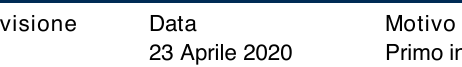

In [41]:
image_path = 'output_0.png'
display(Image(filename=image_path))

In [25]:
html_content = elements[12].metadata.text_as_html

# Utiliza BeautifulSoup para parsear el HTML si es necesario
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')

# Convierte la tabla HTML a un DataFrame de pandas
df = pd.read_html(str(table))[0]

df

,0,1
0,visione,Motivo
1,visione,Primo ir


In [26]:
tablas[0]

,0,1,2
0,visione,Data,Motivo
1,,23 Aprile 2020,Primo in


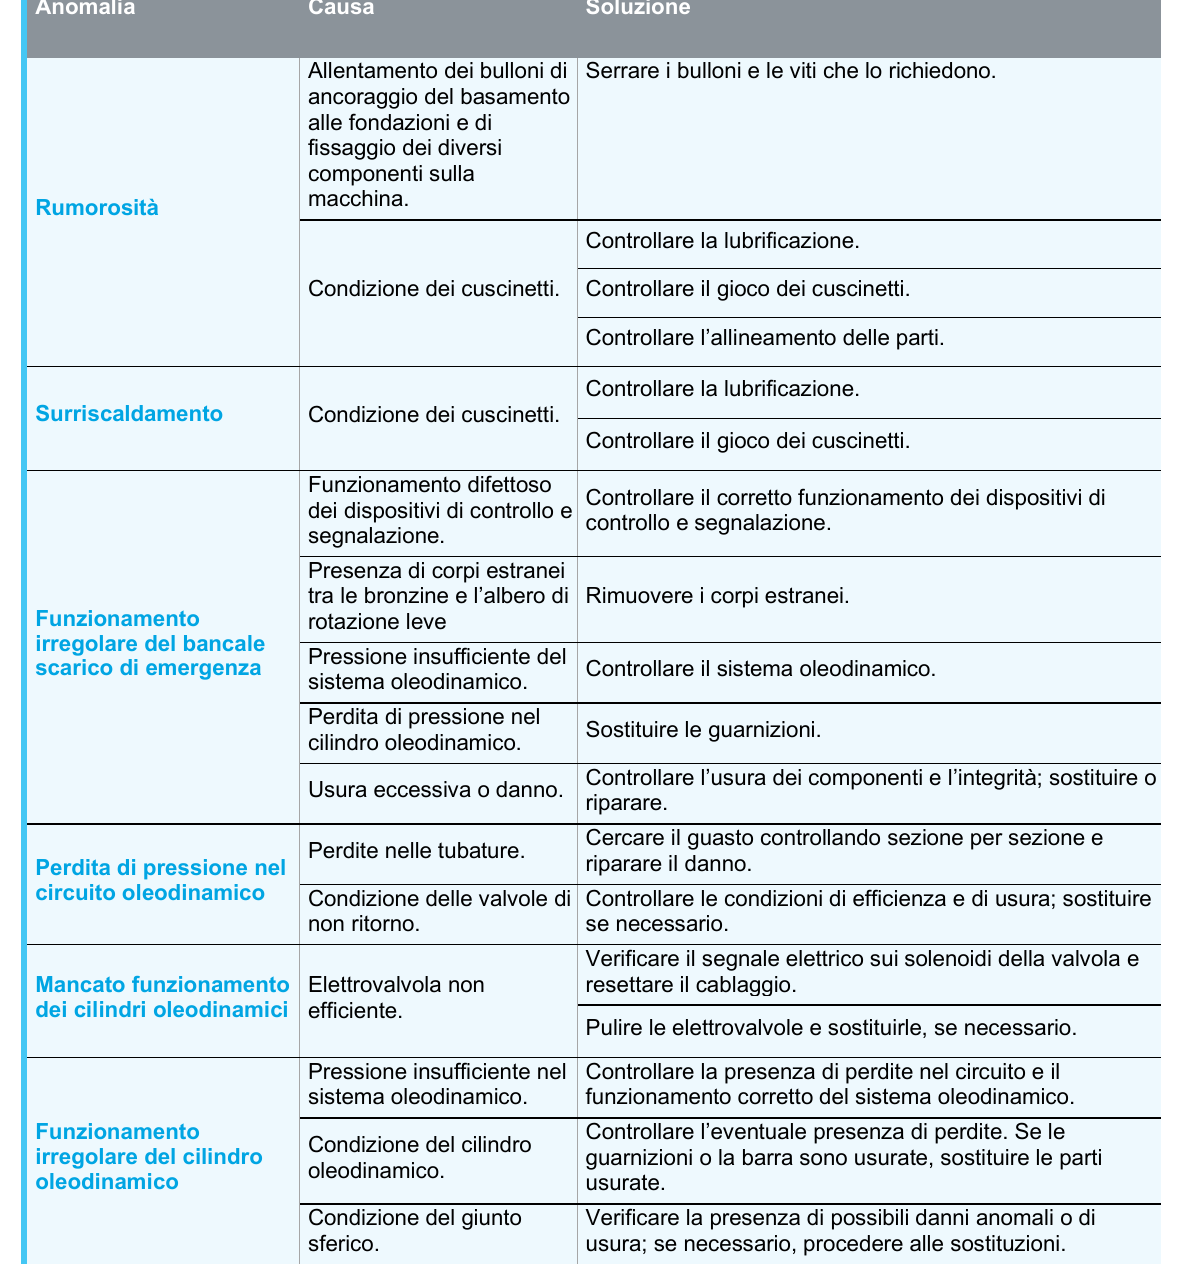

In [42]:
image_path = 'output_1.png'
display(Image(filename=image_path))

In [27]:
html_content = elements[404].metadata.text_as_html

# Utiliza BeautifulSoup para parsear el HTML si es necesario
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')

# Convierte la tabla HTML a un DataFrame de pandas
df = pd.read_html(str(table))[0]

df

,Rumorosita,Allentamento dei bulloni di ancoraggio del basamento alle fondazioni e di fissaggio dei diversi componenti sulla macchina.,Serrare i bulloni e le viti che lo richiedono.
0,NaN,NaN,Controllare la lubrificazione.
1,NaN,Condizione dei cuscinetti.,Controllare il gioco dei cuscinetti.
2,NaN,NaN,Controllare l’allineamento delle parti.
3,Surriscaldamento,Condizione dei cuscinetti.,Controllare la lubrificazione.
4,Surriscaldamento,Condizione dei cuscinetti.,Controllare il gioco dei cuscinetti.
5,Funzionamento irregolare del bancale scarico d...,Funzionamento difettoso dei dispositivi di con...,Controllare il corretto funzionamento dei disp...
6,Funzionamento irregolare del bancale scarico d...,Presenza di corpi estranei tra le bronzine e l...,Rimuovere i corpi estranei.
7,Funzionamento irregolare del bancale scarico d...,Pressione insufficiente del sistema oleodinamico.,Controllare il sistema oleodinamico.
8,Funzionamento irregolare del bancale scarico d...,Perdita di pressione nel cilindro oleodinamico.,Sostituire le guarnizioni.
9,Funzionamento irregolare del bancale scarico d...,Usura eccessiva o danno.,Controllare l’usura dei componenti e l’integri...


In [28]:
tablas[1]

,0,1,2
0,Anomalia,Causa,Soluzione
1,Rumorosità,Allentamento dei bulloni di ancoraggio del bas...,Serrare i bulloni e le viti che lo richiedono.
2,,Condizione dei cuscinetti.,Controllare la lubrificazione.
3,,,Controllare il gioco dei cuscinetti.
4,,,Controllare l'allineamento delle parti.
5,Surriscaldamento,Condizione dei cuscinetti.,Controllare la lubrificazione.
6,,,Controllare il gioco dei cuscinetti.
7,Funzionamento irregolare del bancale scarico d...,Funzionamento difettoso dei dispositivi di con...,Controllare il corretto funzionamento dei disp...
8,,Presenza di corpi estranei tra le bronzine e l...,Rimuovere i corpi estranei.
9,,Pressione insufficiente del sistema oleodinami...,Controllare il sistema oleodinamico.


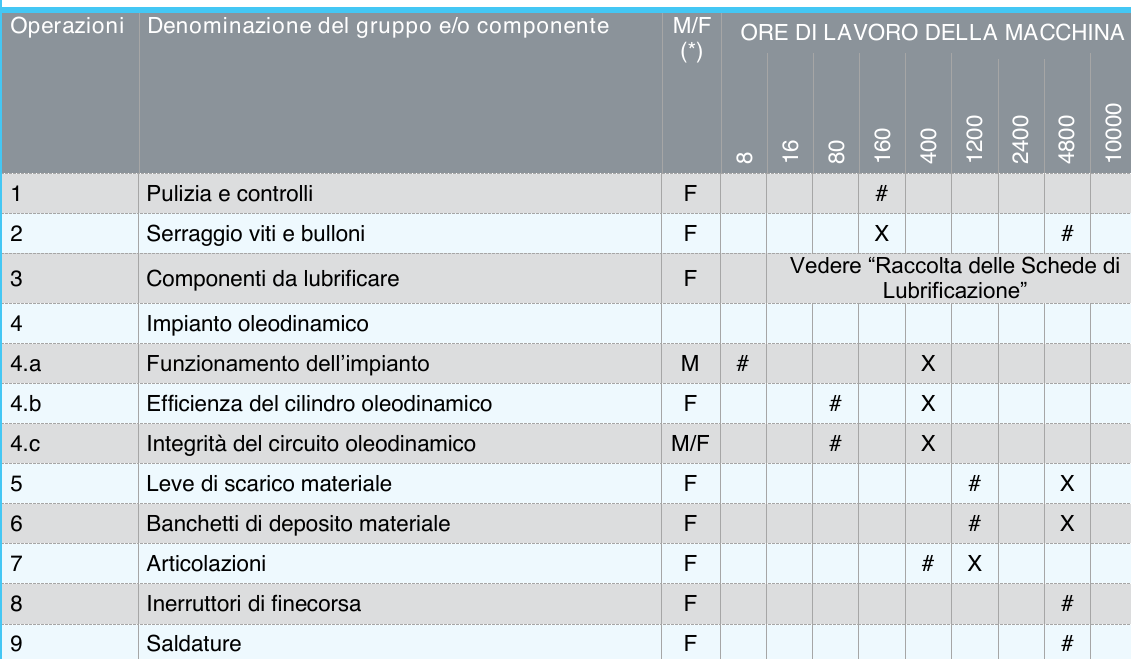

In [43]:
image_path = 'output_2.png'
display(Image(filename=image_path))

In [29]:
html_content = elements[608].metadata.text_as_html

# Utiliza BeautifulSoup para parsear el HTML si es necesario
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')

# Convierte la tabla HTML a un DataFrame de pandas
df = pd.read_html(str(table))[0]

df

,Operazioni,Denominazione del gruppo e/o componente,M/F,ORE,DI,LAVORO fo) @,Unnamed: 6,DELLA,MACCHINA,Unnamed: 9
0,1,Pulizia e controlli,F,NaN,NaN,#,NaN,NaN,NaN,NaN
1,2,Serraggio viti e bulloni,(F,NaN,NaN,xX,NaN,NaN,#,NaN
2,3,q Componenti da lubrificare,F,NaN,Vedere,NaN,“Raccolta lubrificazione”,delle,Schede,di
3,4,Impianto oleodinamico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.a,Funzionamento dell'impianto,M,#,NaN,NaN,X,NaN,NaN,NaN
5,4.b,Efficienza del cilindro oleodinamico,F,NaN,#,NaN,Xx,NaN,NaN,NaN
6,5,Leve di scarico materiale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,6,Banchetti di deposito materiale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7,Articolazioni,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,8,Inerruttori di finecorsa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
tablas[2]

,0,1,2,3,4,5,6,7,8,9,10,11
0,Operazioni,Denominazione del gruppo e/o componente,M/F (*),ORE DI LAVORO DELLA MACCHINA,,,,,,,,
1,,,,8,16 1,00,160,400,1200,2000,# [ ],00000
2,1,Pulizia e controlli,F,,,,#,,,,,
3,2,Serraggio viti e bulloni,F,[ ],[ ],[ ],[X],[ ],[ ],[ ],#,[ ]
4,3,Componenti da lubrificare,F,,"Vedere ""Raccolta delle Schede di Lubrificazione""",,,,,,,
5,4,Impianto oleodinamico,,,[ ],[ ],[ ],[ ],[ ],[ ],[ ],[ ]
6,4.a,Funzionamento dell'impianto,M,#,[ ],,[ ],[X],[ ],[ ],[ ],[ ]
7,4.b,Efficienza del cilindro oleodinamico,F,[ ],[ ],#,[ ],[X],[ ],[ ],[ ],[ ]
8,4.c,Integrità del circuito oleodinamico,M/F,,[ ],#,[ ],[X],[ ],[ ],[ ],[ ]
9,5,Leve di scarico materiale,F,[ ],[ ],[ ],[ ],[ ],#,[ ],[X],[ ]


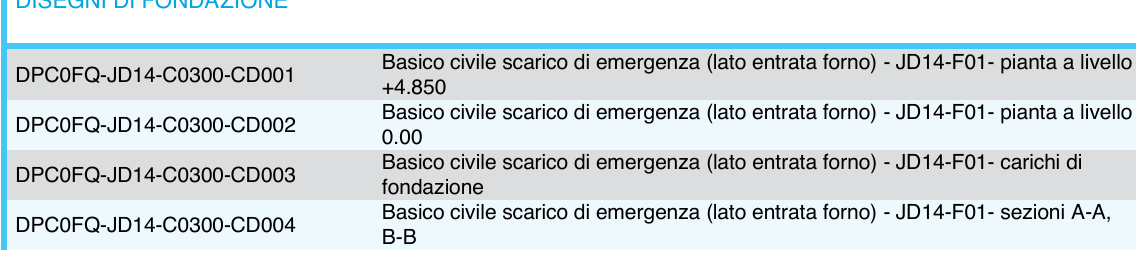

In [45]:
image_path = 'output_3.png'
display(Image(filename=image_path))

In [31]:
html_content = elements[734].metadata.text_as_html

# Utiliza BeautifulSoup para parsear el HTML si es necesario
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')

# Convierte la tabla HTML a un DataFrame de pandas
df = pd.read_html(str(table))[0]

df

,0,1,2
0,DPCOFQ-JD14-C0300-CD001,Basico civile scarico di emergenza (lato entra...,- JD14-F01- pianta a livello
1,DPCOFQ-JD14-C0300-CD002,Basico civile scarico di emergenza (lato entra...,- JD14-F01- pianta a livello
2,DPCOFQ-JD14-C0300-CD003,Basico civile scarico di emergenza (lato entra...,- JD14-F01- carichi di
3,DPCOFQ-JD14-C0300-CD004,Basico civile scarico di emergenza (lato entra...,"- JD14-F01- sezioni A-A,"


In [32]:
tablas[3]

,0,1
0,DPC0FQ-JD14-C0300-CD001,Basico civile scarico di emergenza (lato entra...
1,DPC0FQ-JD14-C0300-CD002,Basico civile scarico di emergenza (lato entra...
2,DPC0FQ-JD14-C0300-CD003,Basico civile scarico di emergenza (lato entra...
3,DPC0FQ-JD14-C0300-CD004,Basico civile scarico di emergenza (lato entra...


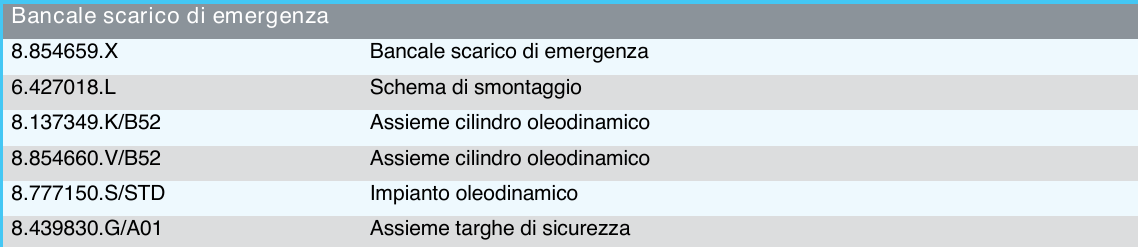

In [46]:
image_path = 'output_4.png'
display(Image(filename=image_path))

In [33]:
html_content = elements[738].metadata.text_as_html

# Utiliza BeautifulSoup para parsear el HTML si es necesario
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')

# Convierte la tabla HTML a un DataFrame de pandas
df = pd.read_html(str(table))[0]

df

,0,1
0,8.854659.X,Bancale scarico di emergenza
1,6.427018.L,Schema di smontaggio
2,8.137349.K/B52,Assieme cilindro oleodinamico
3,8.854660. V/B52,Assieme cilindro oleodinamico
4,8.777150.S/STD,Impianto oleodinamico
5,8.439830.G/A01,Assieme targhe di sicurezza


In [35]:
tablas[4]

,0,1
0,Bancale scarico di emergenza,
1,8.854659.X,Bancale scarico di emergenza
2,6.427018.L,Schema di smontaggio
3,8.137349.K/B52,Assieme cilindro oleodinamico
4,8.854660.V/B52,Assieme cilindro oleodinamico
5,8.777150.S/STD,Impianto oleodinamico
6,8.439830.G/A01,Assieme targhe di sicurezza


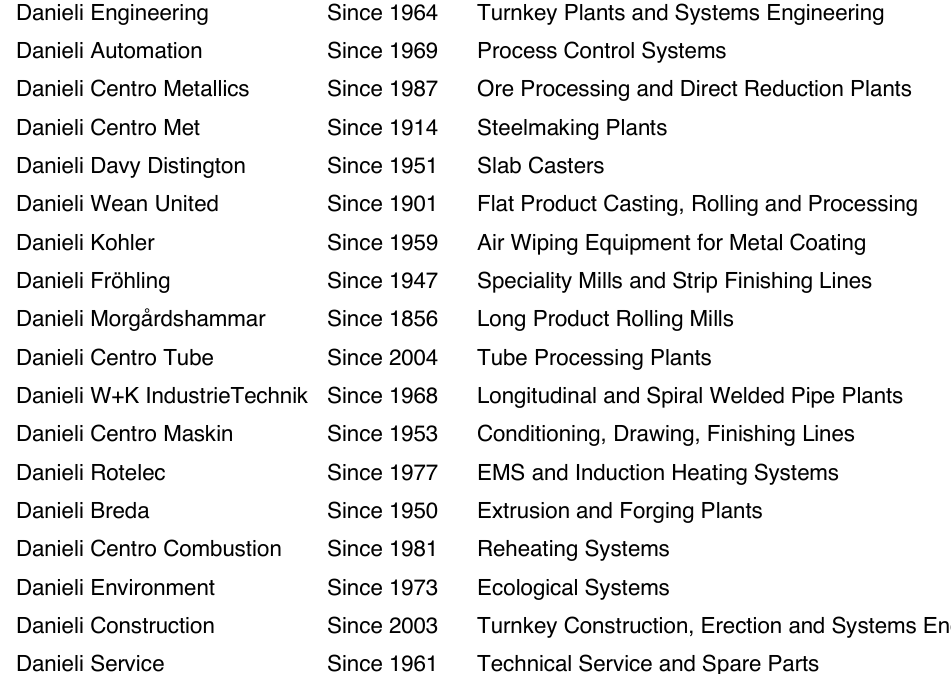

In [47]:
image_path = 'output_5.png'
display(Image(filename=image_path))

In [36]:
html_content = elements[764].metadata.text_as_html

# Utiliza BeautifulSoup para parsear el HTML si es necesario
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')

# Convierte la tabla HTML a un DataFrame de pandas
df = pd.read_html(str(table))[0]

df

,0,1,2
0,Danieli Automation,Since 1969,Process Control Systems
1,Danieli Centro Metallics,Since 1987,Ore Processing and Direct Reduction Plants
2,Danieli Centro Met,Since 1914,Steelmaking Plants
3,Danieli Davy Distington,Since 1951,Slab Casters
4,Danieli Wean United,Since 1901,"Flat Product Casting, Rolling and Processing"
5,Danieli Kohler,Since 1959,Air Wiping Equipment for Metal Coating
6,Danieli Frohling,Since 1947,Speciality Mills and Strip Finishing Lines
7,Danieli Morgardshammar,Since 1856,Long Product Rolling Mills
8,Danieli Centro Tube,Since 2004,Tube Processing Plants
9,Danieli W+K IndustrieTechnik,Since 1968,Longitudinal and Spiral Welded Pipe Plants


In [37]:
tablas[5]

,0,1,2
0,Danieli Engineering,Since 1964,Turnkey Plants and Systems Engineering
1,Danieli Automation,Since 1969,Process Control Systems
2,Danieli Centro Metallics,Since 1987,Ore Processing and Direct Reduction Plants
3,Danieli Centro Met,Since 1914,Steelmaking Plants
4,Danieli Davy Distington,Since 1951,Slab Casters
5,Danieli Wean United,Since 1901,"Flat Product Casting, Rolling and Processing"
6,Danieli Kohler,Since 1959,Air Wiping Equipment for Metal Coating
7,Danieli Fröhling,Since 1947,Speciality Mills and Strip Finishing Lines
8,Danieli Morgardshammar,Since 1856,Long Product Rolling Mills
9,Danieli Centro Tube,Since 2004,Tube Processing Plants


In [ ]:
xxxx

In [ ]:
args = parse_command_line_arguments()
elements = partition_pdf(filename=args.document_path, infer_table_structure=True, include_page_breaks=True, languages=['ita', 'eng'])
all_counter = prepare_counter(elements=elements)

parsed_doc = create_parsed_dictionary(elements, all_counter)

save_path = args.document_path.replace('.pdf', '.json')
save_parsed_document(parsed_doc, save_path)